In [1]:
import matplotlib
from matplotlib import pyplot as plt
from PIL import Image
import torch
from transformers import GLPNImageProcessor, GLPNForDepthEstimation


#### GLPNImageProcessor.from_pretrained(""vinvino02/glpn-nyu"")- this line loads a pre trained image processor called GLPN(GLOBAL LOCAL PATH NETWORKS) from the "vinvino02/glpn-nyu" this repository . the image processor is responsible for preparing and transforming images into the format required by the model
#### `model = GLPNForDepthEstimation.from_pretrained("vinvino02/glpn-nyu") this line loads the actual pre-trained GLPN model for depth estimationfrom the same repository .this model was trained on the NYU dataset and can predict depth information from single image

In [2]:
feature_extractor = GLPNImageProcessor.from_pretrained("vinvino02/glpn-nyu")
model = GLPNForDepthEstimation.from_pretrained("vinvino02/glpn-nyu")

In [3]:
# loading and resizing
image = Image.open("CLIF_IMAGE_AI.png").convert("RGB") # open an image file and converts into RGB color mode
new_height = 480 if image.height > 480 else image.height # sets a maximum height of 480 pixels for the image ,if the original height is already less than 480 it keeps original height
new_height -= (new_height % 32)  # adjust the height to be divisible by 32 by subracting the remainder
new_width = int(new_height * image.width / image.height)  # caluculate new width to maintain the original aspect ratio
diff = new_width % 32

new_width = new_width - diff if diff < 16 else new_width + 32 - diff 
new_size = (new_width,new_height) # create a tuple with new dimensions
image = image.resize(new_size)  # resize the image to new dimensions

In [4]:
inputs = feature_extractor(images=image, return_tensors = "pt") # process the input image

In [5]:
with torch.no_grad():         # this context manager disable gradient calculation
    outputs = model(**inputs) # the model is called with input data , inputs unpacks a dictionary of input pass as keyword arguments to the model
    predicted_depth = outputs.predicted_depth # this extracts predicted depth values from model outputs

#### 1. it is used to trim the borders of depth map and image
#### 2. squeez() --> removes unnessary dimensions
#### 3. cpu().numpy() ---> moves it from GPU to cpu and convert numpy 
#### 4. 1000 scale the depth valuesfrom meters to millimeters
#### 5. output ---> this removes 16 pixels wide border from all sides
#### 6. image --->  crops the RGB image to match the trimmed depth map

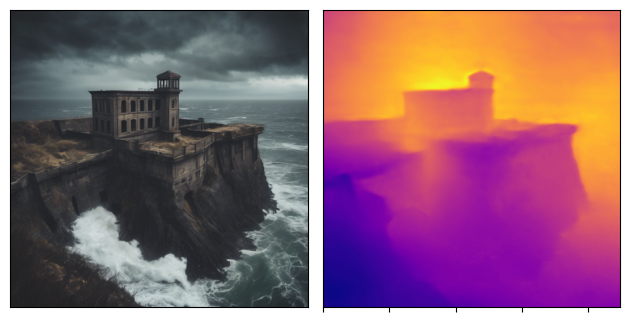

In [6]:
# post processing
pad = 16   
output = predicted_depth.squeeze().cpu().numpy() *1000.0
output = output[pad:-pad,pad:-pad]
image = image.crop((pad,pad,image.width - pad,image.height - pad))

# visualize the prediction
fig, ax = plt.subplots(1,2)
ax[0].imshow(image)
ax[0].tick_params(left=False, bottom=False, labelleft=False,labelbottom=False)
ax[1].imshow(output, cmap='plasma')
ax[1].tick_params(left=False, right=False,labelleft=False,labelbottom=False)
plt.tight_layout()
plt.pause(5)

In [7]:
import numpy as np
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [9]:
# preparing depth image for open3d
if not isinstance(image, np.ndarray):
    image = np.array(image)  
    
width, height = image.shape[:2]    # extract the dimension from the image array by accessing the first two elements of its shpe
depth_image = (output * 255 / np.max(output)).astype('uint8') # scale the to a range 0 - 255 by dividing max output and multiplying 255
image = np.array(image)  # ensure that image is a numpy array

# Resize depth_image to match the dimensions of the RGB image
import cv2  # Make sure cv2 is imported
depth_image_resized = cv2.resize(depth_image, (image.shape[1], image.shape[0]))

# create rgbd image
depth_o3d = o3d.geometry.Image(depth_image_resized)  # Use the resized depth image,this line converts resized depth image into an open3D image
image_o3d = o3d.geometry.Image(image)  # this converts RGB Image into open3D
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth( # it creates RGBD image by combining depth and image
    image_o3d, 
    depth_o3d,
    convert_rgb_to_intensity=False  # Open3D to keep the RGB values as they are, rather than converting them to grayscale intensity values.
)

In [10]:
# create a camera
camera_intrinsic = o3d.camera.PinholeCameraIntrinsic()
camera_intrinsic.set_intrinsics(width, height,500,500,width/2,height/2)

In [11]:
# creating o3d point cloud
pcd_raw = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)
o3d.visualization.draw_geometries([pcd_raw])

#### remove_statistical_outlier --> this removes statistical outliers from the raw point cloud
####  Examining 20 neighoboring points for each point
####  Keeping points whose average distance is within 20 standard deviations of the mean distance
#### PCD ---> creates a new point cloud by selecting only the points identified as inliers
#### Calculates surface normal vectors for each point in the cleaned point cloud
####  Ensures all normal vectors point in a consistent direction

In [12]:
# post processing the 3D point cloud
cl, ind = pcd_raw.remove_statistical_outlier(nb_neighbors=20, std_ratio=20.0) 
pcd = pcd_raw.select_by_index(ind)

# estimate normals
pcd.estimate_normals()
pcd.orient_normals_to_align_with_direction()
o3d.visualization.draw_geometries([pcd])

In [15]:
# surface reconstruction
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=10, n_threads=1)[0]

# rotate the mesh
rotation = mesh.get_rotation_matrix_from_xyz((np.pi,0,0))
mesh.rotate(rotation , center=(0,0,0))

# visualize the mesh
o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)


In [36]:
o3d.io.write_triangle_mesh('clif.obj',mesh) # save a 3D triangle mesh to a file

True